In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4501101%2F7708988%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240227%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240227T061638Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D50b1583c18c97ebaf951ff5d6d10dc7561f1f8f6467d4f23d89ae6e9b32421ebe4d8f520a9267f04bb002da655483bcc89736e37b83b83e6c31779dc27650143492a760af4e5024ae091d4b9dfcd0dbe9f26e2c06924c26a2ae91f7a9a46fafd8c253c4652a9171a39f5925f0d084cefad785b1034027316b7abba2e6cd9bfb8fe64d9b1e1b4d81f8cea47216877af8781600d09cc426660244ba4d95afabf1bb764474227471a1e9ee0c5041a858ef3a0ac456cc1c39775608f4618cd87281729914503f2190817ed09c4d2d2ad6329ab35ab742f73af3080ef0281247e6ea0bb30612e5b4f05537007d13ece45c5707d901d42b089e45e8737c429da79e507'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 34893 bytes downloaded
Downloaded and uncompressed: titanic
Data source import complete.


# 1) Data Preprocessing


In [2]:
# Import packages

import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

In [3]:

train_df = pd.read_csv('/kaggle/input/titanic/train (1).csv')
test_df = pd.read_csv('/kaggle/input/titanic/test (1).csv')

train_df['Title'] = train_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
test_df['Title'] = test_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

imputer = KNNImputer(n_neighbors=5)
train_df['Age'] = imputer.fit_transform(train_df[['Age']])
test_df['Age'] = imputer.transform(test_df[['Age']])

train_df['Deck'] = train_df['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'M')
test_df['Deck'] = test_df['Cabin'].apply(lambda x: x[0] if pd.notna(x) else 'M')

train_df = pd.get_dummies(train_df, columns=['Sex', 'Embarked', 'Title', 'Deck'])
test_df = pd.get_dummies(test_df, columns=['Sex', 'Embarked', 'Title', 'Deck'])

column = set(train_df.columns) - set(test_df.columns)
for col in column:
    test_df[col] = 0
test_df = test_df[train_df.columns]

drop_columns = ['PassengerId', 'Name', 'Ticket', 'Cabin']
train_df = train_df.drop(drop_columns, axis=1)
test_df = test_df.drop(drop_columns + ["Survived"], axis=1)
Y_train = train_df["Survived"]
train_df = train_df.drop("Survived", axis=1)


X_train = pd.DataFrame(train_df, columns=train_df.columns)
X_test = pd.DataFrame(test_df, columns=test_df.columns)


# 2)Learn and Fine tune the Decision tree

In [4]:

# Split the dataset into training and testing sets
X_train, X_value, y_train, y_value = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Initialize the Decision Tree classifier
dt = DecisionTreeClassifier()

# Fit the model to the training data
dt.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = dt.score(X_value, y_value)
print("Accuracy of the Decision Tree:", accuracy)

# Fine-tune the Decision Tree with hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 7,10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring = "accuracy")
grid_search.fit(X_train, y_train)

best_dt_classifier = grid_search.best_estimator_
best_accuracy = best_dt_classifier.score(X_value, y_value)
print("Best Accuracy after Hyperparameter Tuning:", best_accuracy)

Accuracy of the Decision Tree: 0.7597765363128491
Best Accuracy after Hyperparameter Tuning: 0.8100558659217877


# Plotting the Decision Tree

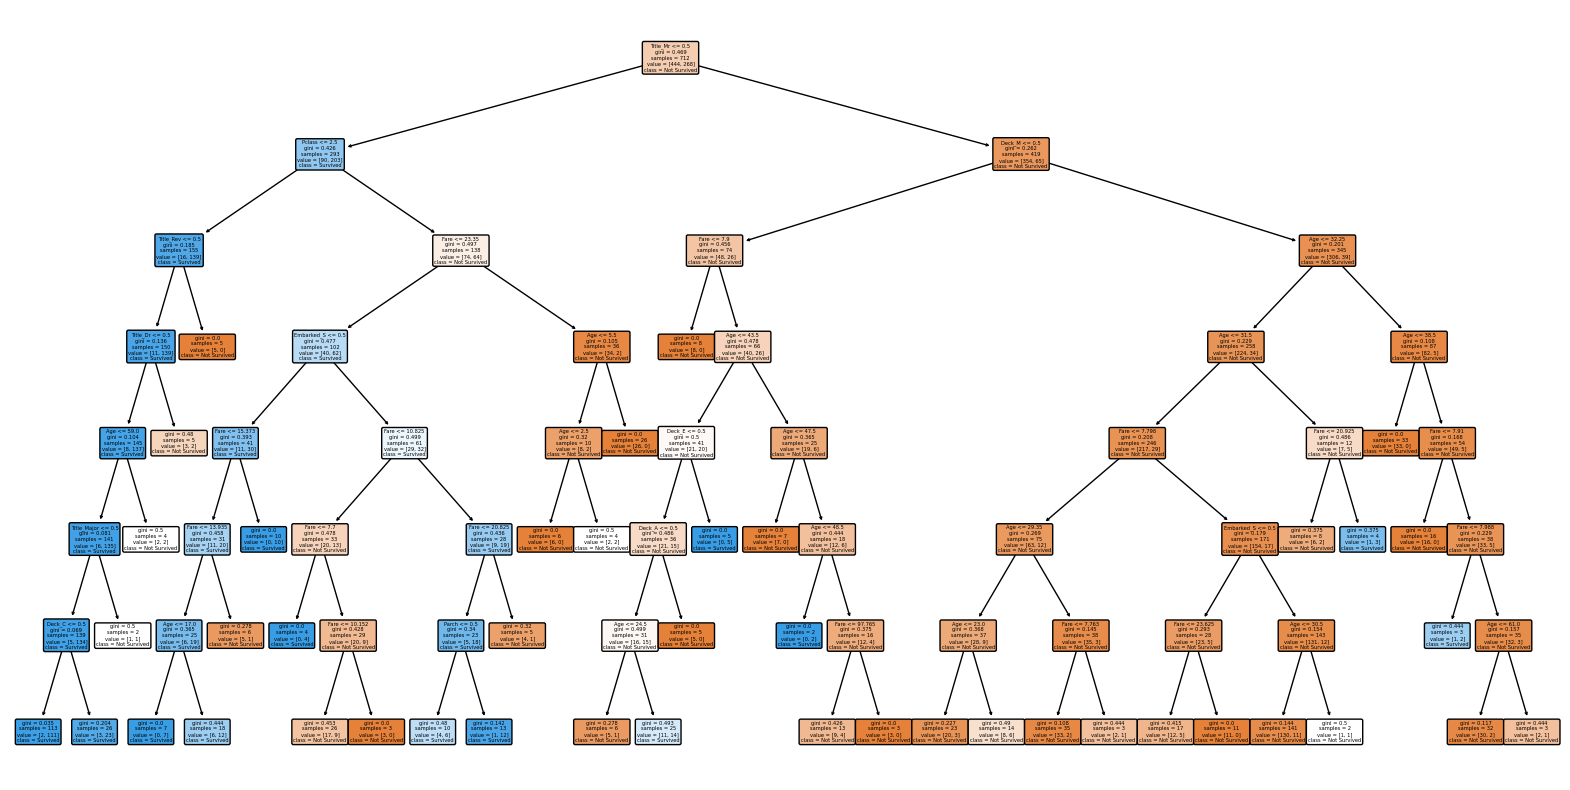

In [5]:
plt.figure(figsize=(20, 10))
plot_tree(best_dt_classifier, filled=True, feature_names=X_train.columns, class_names=['Not Survived', 'Survived'], rounded=True)
plt.show()

# 3) Five Fold CV on Decision Tree, Average Classification Accuracy


In [6]:
from sklearn.model_selection import cross_val_score

# Applying 5-fold cross-validation and calculating the average accuracy
scores = cross_val_score(best_dt_classifier, X_train, y_train, cv=5, scoring='accuracy')
average_accuracy = scores.mean()

print(f'Average Classificaton Accuracy: {average_accuracy:.4f}')

Average Classificaton Accuracy: 0.8203


# 4) Five Fold CV on Random Forest, Average Classification Accuracy

In [8]:


param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

bestrf = grid_search.best_estimator_

scores = cross_val_score(bestrf, X_train, y_train, cv=5, scoring='accuracy')
average_accuracy = scores.mean()

print('Average Classificaton Accuracy:',average_accuracy)

Average Classificaton Accuracy: 0.8455037919826653
